In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
from jax import random, lax
from jax.experimental import optimizers
import jax.numpy as np
import jax.scipy.stats.norm
from jax.api import jit, jacfwd, vmap, value_and_grad, pmap
from jax.config import config
config.update('jax_enable_x64', True)
#config.update("jax_debug_nans", True)
from jax_md import simulate, energy, minimize, quantity
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from utils import ProgressIter, draw_system, draw_lattice, normalise_phase
from simulation import (
    simulate_with_parameters, init_at_temperature, N_A, N_B,
    compute_normalised_phase,
    get_angular_momentum, get_momentum, get_temperature)

In [3]:
T_RANGE = np.linspace(1, 1800, num=5000, dtype=np.float32)
ITERATIONS_PER_TEMPERATURE = 20000
m_A = 3.5
m_B = 1.5
mass = np.array([m_A]*N_A+[m_B]*N_B, dtype=np.float32)

In [4]:
lattice_parameters = np.array([np.pi/2, np.pi/3], dtype=np.float32)

In [5]:
def phase_after_relaxation(key, initial_lattice, initial_temperature, params, lattice_norms):
    init_fn, apply_fn, energy_fun = simulate_with_parameters(**params)
    initial_state = init_at_temperature(key, initial_lattice, initial_temperature, init_fn, mass)
    relaxed_initial_state = lax.scan(lambda s, i: (apply_fn(s), ()), initial_state,
                                     np.arange(ITERATIONS_PER_TEMPERATURE))[0]
    return compute_normalised_phase(relaxed_initial_state.position, N_A, lattice_norms)

In [6]:
def evaluate_lattice(key, lattice):
    keys = random.split(key, len(T_RANGE))
    phases, phases_std = vmap(phase_after_relaxation, in_axes=(0, None, 0, None, None))(
        keys, lattice, T_RANGE, params, lattice_parameters)
    fig, ax = plt.subplots()
    for i in range(phases.shape[1]):
        ax.errorbar(T_RANGE, phases[:, i], phases_std[:, i], label=f"${lattice_parameters[i]/np.pi:.2f}\pi$");
    ax.legend()
    return phases, phases_std

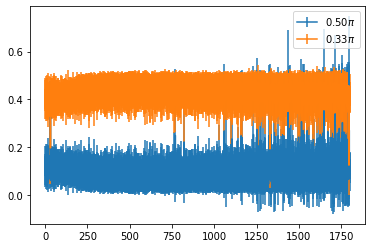

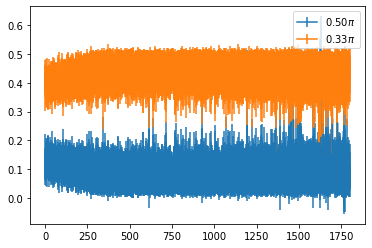

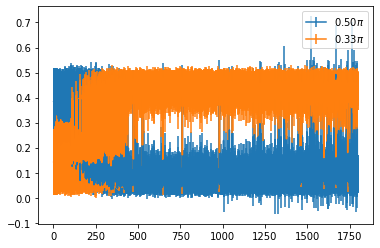

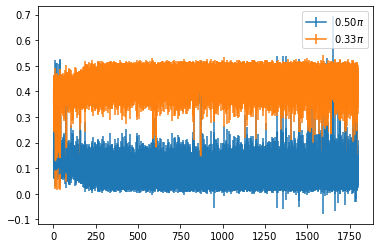

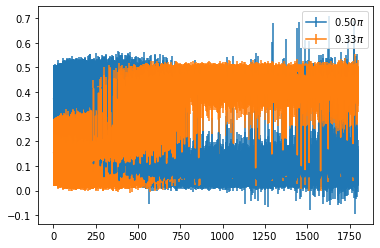

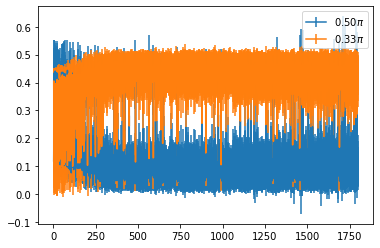

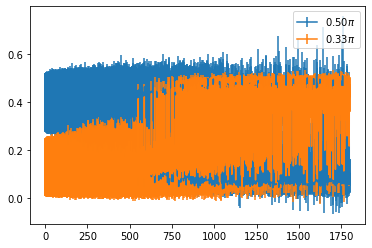

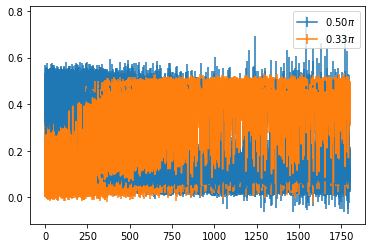

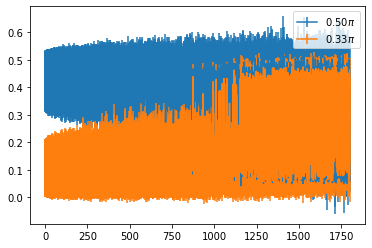

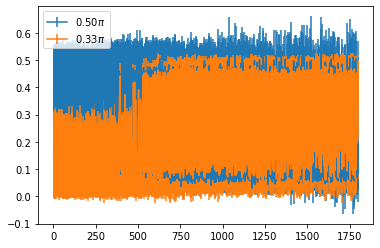

In [ ]:
key = random.PRNGKey(3212312)
for energy_delta_ev in (0.,0.25,0.5,1.,1.5,2.):
    lattices, energies, epsilon, sigma = map(np.array, np.load(f"data/delta_{energy_delta_ev}_eV.npz").values())
    params = {'epsilon': epsilon, 'sigma': sigma}
    key, subkey = random.split(key)
    keys = random.split(subkey, len(lattices))
    all_phases = list(map(evaluate_lattice, keys, lattices))
    np.savez(f"data/results_{energy_delta_ev}_eV.npz", all_phases)